In [36]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
from scipy.stats import norm, uniform
import corner
%matplotlib inline
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (7, 5),
    "xtick.top": True,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}


mpl.rcParams.update(params)


In [3]:
data_path = '/mnt/ceph/users/wwong/GWProject/JaxGW/RealtimePE/ppPlots/injection_0.npz'
data = np.load(data_path)
chains = data['chains']
true_param = data['true_param']
print(true_param)
print(data['local_accs'].mean(),data['global_accs'].mean(),data['log_prob'].mean())
print(data['true_log_prob'])

[ 1.32596611e+01  2.23837734e-01 -2.57752574e-01  1.90366052e-01
  1.05185065e+03  2.45513561e-01  5.73357951e+00  4.61125436e-01
  2.84415670e+00  3.94116461e+00  1.39966765e-02]
0.3293969849246231 0.3485075376884422 213.68014348997855
216.8159238593497


In [206]:
q_axis = np.linspace(0.1,1,10000)
eta = q_axis/(1+q_axis)**2
q_interp = interp1d(eta,q_axis)
true_param[1] = q_interp(true_param[1])
true_param[7] = np.cos(true_param[7])
true_param[10] = np.sin(true_param[10])

In [207]:
for i in range(11):print(np.where(chains[:,:,i]<true_param[i])[0].shape[0]/chains[:,:,i].size)

0.0
0.2804925
0.99045625
0.3117975
0.5384325
0.38452
0.42758
0.0627275
0.70695
0.990815
0.0104925


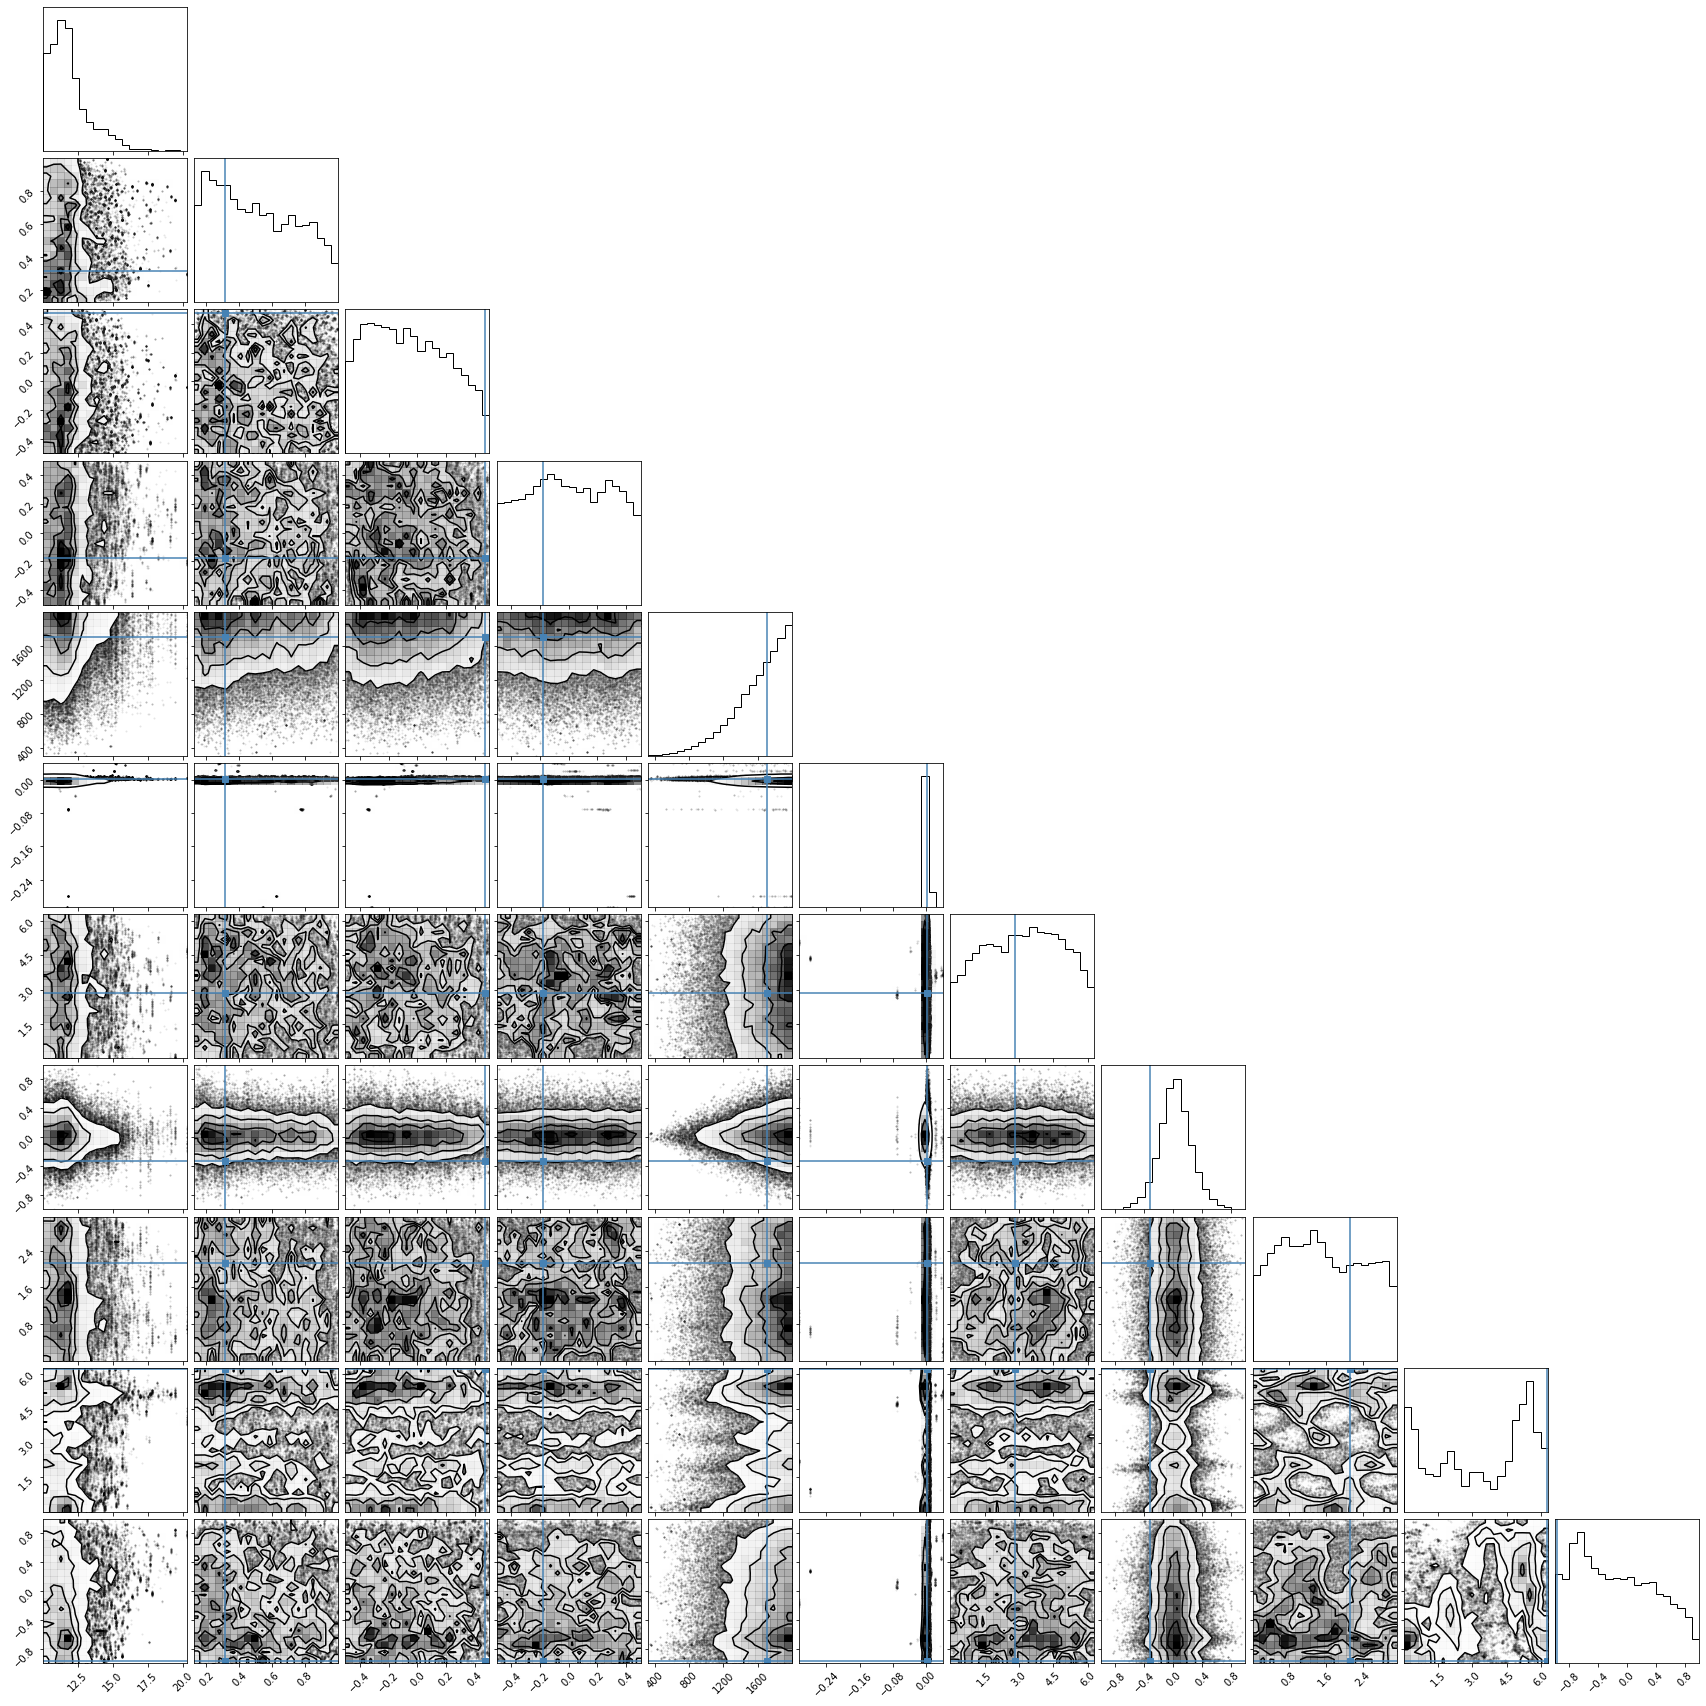

In [208]:
fig = corner.corner(chains.reshape(-1,11)[::10],truths=true_param)

In [56]:
ppPlot_data = np.load('/mnt/home/wwong/ceph/GWProject/JaxGW/RealtimePE/ppPlots/combined_quantile_balance_LVK.npz')
result = ppPlot_data['result']
result_multimodal = ppPlot_data['result_multimodal']
true_param = ppPlot_data['true_param']
mean_global_accs = ppPlot_data['mean_global_accs']
mean_local_accs = ppPlot_data['mean_local_accs']

In [57]:
def makeCumulativeHist(data):
    h = np.histogram(data,bins=100,range=(0,1),density=True)
    return np.cumsum(h[0])/100.

N = 10000
uniform_data = np.random.uniform(size=(N,1000))
cum_hist = []
for i in range(N):
    cum_hist.append(makeCumulativeHist(uniform_data[i]))
cum_hist = np.array(cum_hist)
upper_quantile_array = []
lower_quantile_array = []
percentile = 0.05
for i in range(100):
    upper_quantile_array.append(np.quantile(cum_hist[:,i],(1-percentile/2)))
    lower_quantile_array.append(np.quantile(cum_hist[:,i],(percentile/2)))

Text(0.5, 1.0, 'Combined p-value: 0.698')

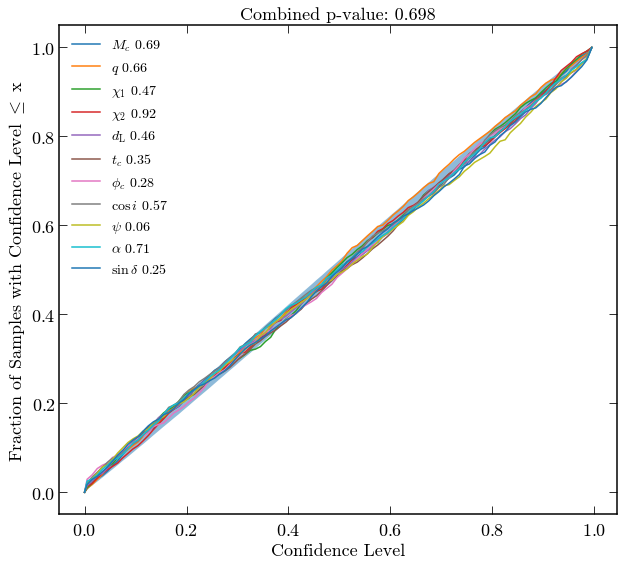

In [112]:
from scipy.stats import kstest
axis_labels=  [r'$M_c$', r'$q$', r'$\chi_1$', r'$\chi_2$', r'$d_{\rm{L}}$', r'$t_c$', r'$\phi_c$', r'$\cos{i}$', r'$\psi$', r'$\alpha$', r'$\sin{\delta}$']

start = 0
count = 1200
plt.figure(figsize=(10,9))
bins = np.linspace(0,1,101)
bins = (bins[1:]+bins[:-1])/2
plt.fill_between(bins,lower_quantile_array,upper_quantile_array,alpha=0.5)
pvalues = []
for i in range(11):
    pvalues.append(kstest(result[start:start+count,i],cdf=uniform(0,1).cdf).pvalue)
    plt.plot(np.append(0,bins),np.append(0,makeCumulativeHist(result[start:start+count,i])), label=axis_labels[i]+" "+str(round(pvalues[-1],2)))
plt.legend(loc='upper left',fontsize=14)
plt.xlabel(r'Confidence Level')
plt.ylabel(r'Fraction of Samples with Confidence Level $\leq$ x')
plt.title('Combined p-value: '+str(round(kstest(pvalues,cdf=uniform(0,1).cdf).pvalue,3)))

In [62]:
kstest(pvalues,cdf=uniform.cdf)

KstestResult(statistic=0.36469647931640514, pvalue=0.08102220470941102)

In [51]:
pvalues = []
for i in range(11):
    pvalues.append(kstest(result[:,i],cdf=uniform(0,1).cdf).pvalue)
print(kstest(pvalues,uniform(0,1).cdf))

KstestResult(statistic=0.24252371720146648, pvalue=0.4652064216351961)